## Intelligent Complaint Analysis

This system is designed to analyze customer complaints across the following financial product categories:

- **Credit Card**: Includes issues related to billing disputes, unauthorized transactions, APR confusion, and credit limit concerns.
- **Personal Loan**: Covers complaints such as hidden fees, unclear loan terms, payment difficulties, and debt collection practices.
- **Buy Now, Pay Later (BNPL)**: Focuses on complaints involving payment delays, refund issues, and deceptive interest disclosures.
- **Savings Account**: Analyzes concerns related to account freezes, unrecognized withdrawals, interest rate changes, and minimum balance requirements.
- **Money Transfer**: Investigates delays, transaction failures, incorrect account deposits, and excessive service charges.


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt 
import seaborn as sns

KeyboardInterrupt: 

In [2]:
from pathlib import Path

# Get project root relative to the current script location
BASE_DIR = Path.cwd().parent  # Go up to the project root
data_path = BASE_DIR / "data" / "raw" / "complaints.csv"

if data_path.exists():
    df = pd.read_csv(data_path)
else:
    raise FileNotFoundError(f"File not found at {data_path}")

C:\Users\herko\AppData\Local\Temp\ipykernel_16248\850232263.py:8: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [3]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


In [4]:
df.describe()
# df.info()

,Complaint ID
count,9.609797e+06
mean,8.092744e+06
std,3.774842e+06
min,1.000000e+00
25%,5.038016e+06
50%,8.448508e+06
75%,1.129591e+07
max,1.423259e+07


In [5]:
# NaN count and percentile of the whole data

nan_info = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_percent": df.isna().mean() * 100
})

In [6]:
percentiles = df.describe(percentiles=[.25, .5, .75, .9, .95]).T
print("NaN count and Percent: \n", nan_info)
print("\nPercentiles: \n", percentiles)

NaN count and Percent: 
                               missing_count  missing_percent
Date received                             0         0.000000
Product                                   0         0.000000
Sub-product                          235295         2.448491
Issue                                     6         0.000062
Sub-issue                            839522         8.736105
Consumer complaint narrative        6629041        68.982113
Company public response             4770207        49.638999
Company                                   0         0.000000
State                                 54516         0.567296
ZIP code                              30228         0.314554
Tags                                8981029        93.457011
Consumer consent provided?          1649561        17.165409
Submitted via                             0         0.000000
Date sent to company                      0         0.000000
Company response to consumer             20         0.000208

### **Summary**
NaN count and Missing percent

Columns with 0% Missing:
- Date received
- Product
- Company
- Submitted via
- Date sent to company
- Timely response?
- Complaint ID

Columns with Low Missing ( < 1% )
- Sub-product: 2.44%
- Issue: 0.00006%
- State: 0.56%
- ZIP code: 0.31%
- Company response to consumer: 0.0002%

Moderate Missing (10–50%)
- Consumer consent provided?: 17.16%
- Company public response: 49.64

Very High Missing ( > 50%)
- Consumer complaint narrative: 68.98%
- Tags: 93.45%
- Consumer disputed?: 92.00%

In [7]:
# sidtribution of caomplaints across different Products 
product_counts = df['Product'].value_counts()

In [8]:
# word counts for the consumer complaints narrative 
df['narrative_word_count'] = df['Consumer complaint narrative'].dropna().apply(lambda x: len(str(x).split()))

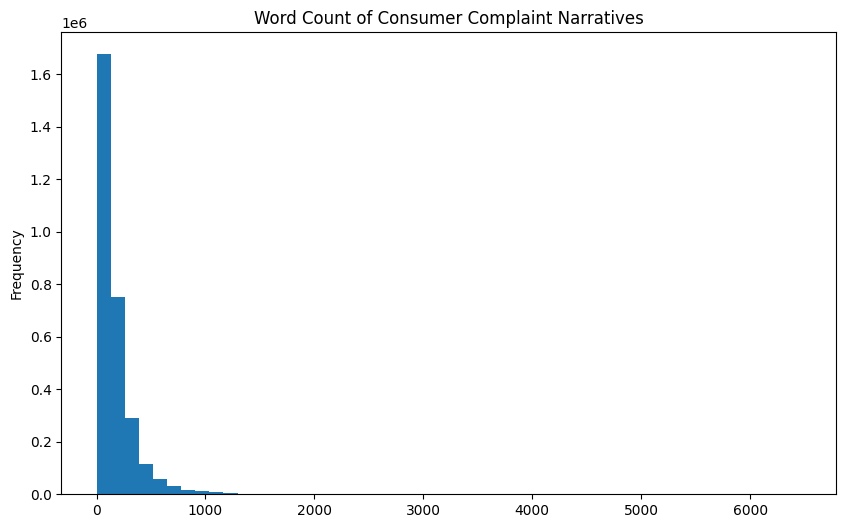

In [9]:
# Histogram of narrative lengths
word_count_plot = df['narrative_word_count'].dropna().plot(kind='hist',
                                                            bins=50, figsize=(10, 6), 
                                                            title='Word Count of Consumer Complaint Narratives')

In [11]:
# Count complaints with and without narratives
with_narrative = df['Consumer complaint narrative'].notna().sum()
without_narrative = df['Consumer complaint narrative'].isna().sum()


In [12]:
# Filter dataset to include only specified products and non-empty narratives
target_products = [
    "Credit card", "Personal loan", 
    "Buy Now, Pay Later (BNPL)", 
    "Savings account", "Money transfers"
]

filtered_df = df[
    (df['Product'].isin(target_products)) & 
    (df['Consumer complaint narrative'].notna())
].copy()

In [13]:
# Clean the narrative text
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove special characters
    text = re.sub(r"\bi am writing to (file|submit) a complaint.*", "", text)  # remove boilerplate
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [14]:
filtered_df['cleaned_narrative'] = filtered_df['Consumer complaint narrative'].apply(clean_text)

# Save the cleaned dataset
output_path = "../data/processed/filtered_complaints.csv"
filtered_df.to_csv(output_path, index=False)

In [15]:
# Summarize results
summary = {
    "initial_row_count": len(df),
    "row_with_narratives": with_narrative,
    "row_without_narratives": without_narrative,
    "unique_products": df['Product'].nunique(),
    "filtered_row_count": len(filtered_df),
    "filtered_product_distribution": filtered_df['Product'].value_counts().to_dict()
}

summary

{'initial_row_count': 9609797,
 'row_with_narratives': np.int64(2980756),
 'row_without_narratives': np.int64(6629041),
 'unique_products': 21,
 'filtered_row_count': 82164,
 'filtered_product_distribution': {'Credit card': 80667,
  'Money transfers': 1497}}

In [3]:
# load filtered_data
filtered_ddf = pd.read_csv("../data/processed/filtered_complaints.csv")
filtered_ddf.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,narrative_word_count,cleaned_narrative
0,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78230,Servicemember,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121,91.0,a xxxx xxxx card was opened under my name by a...
1,2025-06-12,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,"Dear CFPB, I have a secured credit card with c...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,11220,NaN,Consent provided,Web,2025-06-13,Closed with monetary relief,Yes,NaN,14047085,156.0,dear cfpb i have a secured credit card with ci...
2,2025-06-12,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account information incorrect,I have a Citi rewards cards. The credit balanc...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,60067,NaN,Consent provided,Web,2025-06-12,Closed with explanation,Yes,NaN,14040217,233.0,i have a citi rewards cards the credit balance...
3,2025-06-09,Credit card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,b'I am writing to dispute the following charge...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78413,Older American,Consent provided,Web,2025-06-09,Closed with monetary relief,Yes,NaN,13968411,454.0,bi am writing to dispute the following charges...
4,2025-06-09,Credit card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,"Although the account had been deemed closed, I...",Company believes it acted appropriately as aut...,Atlanticus Services Corporation,NY,11212,Older American,Consent provided,Web,2025-06-09,Closed with monetary relief,Yes,NaN,13965746,170.0,although the account had been deemed closed i ...


In [4]:
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
import chromadb
from chromadb.config import Settings

d:\CodeFiles\Kifiya\week6\creditrust-rag-chatbot\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,       # Chosen to balance context and embedding performance
    chunk_overlap=50,     # Helps preserve context across splits
    separators=["\n\n", "\n", ".", "!", "?", " "]
)

text_splitter


In [9]:
filtered_ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82164 entries, 0 to 82163
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date received                 82164 non-null  object 
 1   Product                       82164 non-null  object 
 2   Sub-product                   63327 non-null  object 
 3   Issue                         82164 non-null  object 
 4   Sub-issue                     61770 non-null  object 
 5   Consumer complaint narrative  82164 non-null  object 
 6   Company public response       39566 non-null  object 
 7   Company                       82164 non-null  object 
 8   State                         81857 non-null  object 
 9   ZIP code                      82164 non-null  object 
 10  Tags                          14889 non-null  object 
 11  Consumer consent provided?    82164 non-null  object 
 12  Submitted via                 82164 non-null  object 
 13  D

In [12]:
print(filtered_ddf.isnull().sum())

Date received                       0
Product                             0
Sub-product                     18837
Issue                               0
Sub-issue                       20394
Consumer complaint narrative        0
Company public response         42598
Company                             0
State                             307
ZIP code                            0
Tags                            67275
Consumer consent provided?          0
Submitted via                       0
Date sent to company                0
Company response to consumer        0
Timely response?                    0
Consumer disputed?              61830
Complaint ID                        0
narrative_word_count                0
cleaned_narrative                   0
dtype: int64


In [ ]:
documents = []
metadatas = []

filtered_ddf['Product'] = filtered_ddf['Product'].astype('category')


filtered_ddf['Complaint ID'] = filtered_ddf['Complaint ID'].astype(str)

filtered_ddf['cleaned_narrative'] = filtered_ddf['cleaned_narrative'].fillna('').astype(str)

for idx, row in filtered_ddf.iterrows():
    chunks = text_splitter.split_text(row['cleaned_narrative'])
    for i, chunk in enumerate(chunks):
        documents.append(chunk)
        metadatas.append({
            "complaint_id": row['Complaint ID'],
            "product": row['Product'],
            "chunk_index": i
        })

print(f"Total text chunks: {len(documents)}")

Total text chunks: 378614


In [16]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

In [ ]:
import os

embeddings = embedder.encode(documents, show_progress_bar=True, convert_to_numpy=True)

# Index in Chroma Vector Store
persist_path = "vector_store/chroma_db"
os.makedirs(persist_path, exist_ok=True)

chroma_client = chromadb.PersistentClient(path=persist_path)
collection = chroma_client.get_or_create_collection(name="complaint_chunks")

Batches:  20%|█▉        | 2345/11832 [10:11<38:27,  4.11it/s]  

In [ ]:
from tqdm import tqdm

ids = [f"chunk_{i}" for i in range(len(documents))]


batch_size = 5000  # Safe margin under 5461
total_chunks = len(documents)  # Make sure `documents`, `ids`, `metadatas` are all same length

print(f"Total text chunks: {total_chunks}")

for i in tqdm(range(0, total_chunks, batch_size), desc="Uploading to Chroma"):
    batch_docs = documents[i:i+batch_size]
    batch_ids = ids[i:i+batch_size]
    batch_metadatas = metadatas[i:i+batch_size]

    collection.add(
        documents=batch_docs,
        ids=batch_ids,
        metadatas=batch_metadatas
    )

Total text chunks: 378614


Uploading to Chroma:   0%|          | 0/76 [00:00<?, ?it/s]


NameError: name 'ids' is not defined

In [13]:
documents = df['chunk_text'].fillna("").tolist()
ids = df['chunk_id'].astype(str).tolist()
metadatas = df['metadata'].to_dict(orient='records')


NameError: name 'df' is not defined